In [256]:
import numpy as np
import pandas as pd
import re
import nltk
import math
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [172]:
def make_quota(a, b):
    if math.isnan(b):
        return a
    else:
        return min(a, b)

def to_class(x):
    '''
    0~10萬
    10~30萬(不含10萬)
    30~50萬(不含30萬)
    50~100萬(不含50萬)
    '''
    if x < 1E5:
        return 0
    if 1E5 <= x and x < 3E5:
        return 1
    if 3E5 <= x and x < 5E5:
        return 2
    else:
        return 3

In [173]:
# 玉山資料
df_all = pd.read_csv('./data/ooa_features_v1.csv')

selected_features =[
    'source',
    'age',
    'occupation',
    'hasOtherComAccount',
    'eduLevel',
    'isReject',
    'incomeYear',
    'totalWealth',
    'expInvestment',
    'yrsInvestment',
    'frqInvestment',
    'srcCapital',
    'quotaCredit',
    'quota_now',
    'quota_now_elec',
    'salary',
    'lead_job_id'
]

# data cleaning for model robustness
df_all  = df_all[selected_features]
df_all['y_num'] = df_all[['quota_now', 'quota_now_elec']].apply(lambda x: make_quota(*x), axis=1)
df_all = df_all[df_all['quota_now']<=1e6]
df_all['y_cat'] = df_all['quota_now'].apply(lambda x: to_class(x))
df_all = df_all[df_all['isReject']==0]
df_all = df_all.drop('isReject', axis=1)
df_all = df_all[df_all['source'] != 'Anue']
df_all['salary'] = df_all['salary'].apply(lambda x: abs(x))
df_all = df_all.drop(['quota_now', 'quota_now_elec'], axis=1)
df_all = df_all[df_all['occupation'] <= 33]
df_all = df_all.drop('occupation', axis=1)
df_all = df_all.dropna()
display(df_all.head())

,source,age,hasOtherComAccount,eduLevel,incomeYear,totalWealth,expInvestment,yrsInvestment,frqInvestment,srcCapital,quotaCredit,salary,lead_job_id,y_num,y_cat
0,FUGLE,8,0,2,1,1,0,3,2,0,0,105969,1,500000.0,3
1,FUGLE,8,1,0,1,1,4,3,0,0,0,29817,2,300000.0,3
3,FUGLE,7,1,0,2,2,4,3,3,0,0,129663,1,300000.0,3
4,FUGLE,5,1,0,1,1,3,1,0,0,1,129663,1,300000.0,3
5,玉證,7,1,0,1,0,0,3,2,0,0,35265,4,1000000.0,3


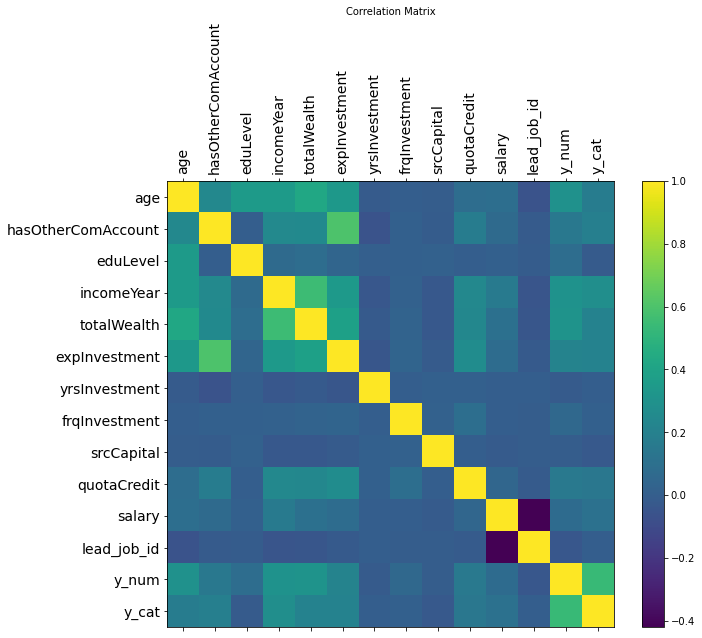

In [174]:
# feature exploration

corr = df_all.corr('pearson')
f = plt.figure(figsize=(10, 8))
plt.matshow(df_all.corr(), fignum=f.number)
plt.xticks(range(df_all.select_dtypes(['number']).shape[1]), df_all.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_all.select_dtypes(['number']).shape[1]), df_all.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10)
plt.show()
plt.close()

In [183]:
df_esun = df_all[df_all['source'] == '玉證']
df_fugle = df_all[df_all['source'] == 'FUGLE']

df_esun = df_esun.drop('source', axis=1)
df_fugle = df_fugle.drop('source', axis=1)

In [184]:
# feature selection

X_fugle = df_fugle.iloc[:, :-1].values
Y_fugle = df_fugle.iloc[:, -1].values

# apply SelectKBest class to extract top 10 best features
top_k = 10
bestfeatures = SelectKBest(score_func=chi2, k=top_k)
fit = bestfeatures.fit(X_fugle, Y_fugle)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(df_fugle.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([df_columns, df_scores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
print(featureScores.nlargest(top_k, 'Score'))  # print 10 best feature
fugle_feature_list = featureScores.nlargest(3, 'Score')['Specs'].values
# df_fugle = df_fugle[fugle_feature_list]


                 Specs         Score
12               y_num  1.559058e+09
10              salary  9.997497e+07
3           incomeYear  3.046351e+03
4          totalWealth  1.185591e+03
0                  age  1.071555e+03
5        expInvestment  1.061011e+03
11         lead_job_id  3.187857e+02
1   hasOtherComAccount  2.855957e+02
9          quotaCredit  2.375803e+02
8           srcCapital  1.565936e+02


In [185]:
# take 1: classify directly

source = 'fugle'
# source = 'esun'

if source == 'fugle':
    X = df_fugle.iloc[:,:-2].values
    Y = df_fugle.iloc[:,-1].values
else:
    X = df_esun.iloc[:,:-2].values
    Y = df_esun.iloc[:,-1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

res_dict = {
    0: {
        'gt': Y_test == 0,
        'pred':Y_pred == 0,
        'range': 'x < 100K'
    },
    1: {
        'gt': Y_test == 1,
        'pred':Y_pred == 1,
        'range': '100K <= x < 300K'
    },
    2: {
        'gt': Y_test == 2,
        'pred':Y_pred == 2,
        'range': '300K <= x < 500K'
    },
    3: {
        'gt': Y_test == 3,
        'pred':Y_pred == 3,
        'range': '500K <= x'
    }
}

print(f'=== {source} ===')

for k, v in res_dict.items():
    print(f'Range {v["range"]}:')
    pred = v['pred']
    gt = v['gt']
    print(f'acc\t= {accuracy_score(pred, gt)}')
    print(f'recall\t= {recall_score(pred, gt)}')
    print(f'f1\t= {f1_score(pred, gt)}')
    print()

=== fugle ===
Range x < 100K:
acc	= 0.9890815671162492
recall	= 0.0
f1	= 0.0

Range 100K <= x < 300K:
acc	= 0.9092930191196087
recall	= 0.7966298663567694
f1	= 0.598951507208388

Range 300K <= x < 500K:
acc	= 0.9916012054740379
recall	= 0.0
f1	= 0.0

Range 500K <= x:
acc	= 0.8939281656044662
recall	= 0.9008099352051836
f1	= 0.9395432658463099



/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# take 2: Add salary and lead_job_id.

In [380]:
# take 3

df_fugle_2 = df_fugle.copy()



cat_list = ['age', 'hasOtherComAccount', 'eduLevel', 'incomeYear', 'totalWealth', 'expInvestment', 'yrsInvestment', 'frqInvestment', 'srcCapital', 'quotaCredit', 'lead_job_id']

dummies = {x: pd.get_dummies(df_fugle[x], drop_first=True) for x in cat_list}
df_fugle_2.drop(cat_list, axis=1, inplace=True)

df_fugle_2 = pd.concat([df_fugle_2] + list(dummies.values()), axis=1)
df_fugle_2 = df_fugle_2.apply(pd.to_numeric)

df_fugle_2['y0'] = df_fugle_2['y_cat'].apply(lambda x: 1 if x == 0 else 0)
df_fugle_2['y1'] = df_fugle_2['y_cat'].apply(lambda x: 1 if x == 1 else 0)
df_fugle_2['y2'] = df_fugle_2['y_cat'].apply(lambda x: 1 if x == 2 else 0)
df_fugle_2['y3'] = df_fugle_2['y_cat'].apply(lambda x: 1 if x == 3 else 0)

Y_list = [df_fugle_2[f'y{i}'].values for i in [0, 1, 2, 3]]
df_fugle_2.drop(['y_num', 'y_cat', 'y0', 'y1', 'y2', 'y3'], axis=1, inplace=True)

X = df_fugle_2.values
X_train, X_test, Y_train_0, Y_test_0, Y_train_1, Y_test_1, Y_train_2, Y_test_2, Y_train_3, Y_test_3 = train_test_split(X, *Y_list, test_size=0.33)

In [382]:
Y_train_list = [Y_train_0, Y_train_1, Y_train_2, Y_train_3]
Y_test_list = [Y_test_0, Y_test_1, Y_test_2, Y_test_3]

# for tr, te in zip(Y_train_list, Y_test_list):
i = 0
print('-'*40, f'{i = }', '-'*40)
clf = LogisticRegression(class_weight={0:1, 1:97})
clf.fit(X_train, Y_train_list[i])
Y_pred = clf.predict(X_test)
print(classification_report(Y_test_list[i], Y_pred))

i = 1
print('-'*40, f'{i = }', '-'*40)
clf = LogisticRegression(class_weight={0:1, 1:10})
clf.fit(X_train, Y_train_list[i])
Y_pred = clf.predict(X_test)
print(classification_report(Y_test_list[i], Y_pred))

i = 2
print('-'*40, f'{i = }', '-'*40)
clf = LogisticRegression(class_weight={0:1, 1:118})
clf.fit(X_train, Y_train_list[i])
Y_pred = clf.predict(X_test)
print(classification_report(Y_test_list[i], Y_pred))

i = 3
print('-'*40, f'{i = }', '-'*40)
clf = LogisticRegression(class_weight={0:1, 1:1})
clf.fit(X_train, Y_train_list[i])
Y_pred = clf.predict(X_test)
print(classification_report(Y_test_list[i], Y_pred))

---------------------------------------- i = 0 ----------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20042
           1       0.01      1.00      0.02       199

    accuracy                           0.01     20241
   macro avg       0.00      0.50      0.01     20241
weighted avg       0.00      0.01      0.00     20241

---------------------------------------- i = 1 ----------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.46      0.61     17344
           1       0.19      0.75      0.30      2897

    accuracy                           0.50     20241
   macro avg       0.55      0.60      0.45     20241
weighted avg       0.81      0.50      0.57     20241

---------------------------------------- i = 2 ----------------------------------------


/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20061
           1       0.00      0.00      0.00       180

    accuracy                           0.99     20241
   macro avg       0.50      0.50      0.50     20241
weighted avg       0.98      0.99      0.99     20241

---------------------------------------- i = 3 ----------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3276
           1       0.84      1.00      0.91     16965

    accuracy                           0.84     20241
   macro avg       0.42      0.50      0.46     20241
weighted avg       0.70      0.84      0.76     20241



/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jack/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [383]:
199 + 2897 + 180 + 16965

20241